# ResNet-18: CIFAR-10 & TF2

__Deep Residual Learning for Image Recognition__ research paper by Kaiming He et al.

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES = 0

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, os, time
import math

from tqdm import tqdm
from tqdm import trange

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.layers import Layer, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal, Constant

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-07-16 10:46:01.444009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:46:01.444243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:46:01.461124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:46:01.461319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:46:01.461498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 80

weight_decay = 0.0005

### CIFAR-10 data pre-processing

In [5]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("'input_shape' which will be used = {0}\n".format(input_shape))

'input_shape' which will be used = (32, 32, 3)



In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [7]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


In [8]:
# Prepare CIFAR10 dataset for TensorFlow GradientTape training:

# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-07-16 10:46:06.450996: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-16 10:46:06.588152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:46:06.588528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 10:46:06.588686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [9]:
train_dataset = train_dataset.\
shuffle(buffer_size = 20000, reshuffle_each_iteration = True).\
batch(batch_size = batch_size, drop_remainder = False)
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [10]:
# Choose loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [11]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

### ResNet-18 architecture

__Deep Residual Learning for Image Recognition__ research paper by Kaiming He et al.

Periodically, we double the number of filters and down sample spatially using stride = 2 (when we do that).

In [12]:
class ResNet_Block(Layer):
    
    def __init__(
        self, num_channels,
        stride = 1, dropout = 0.2,
        use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
    
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = Conv2D(
            filters = self.num_channels, kernel_size = (3, 3),
            strides = self.stride, padding = "same",
            kernel_initializer = tf.keras.initializers.he_normal(),
            use_bias = False
        )
        self.bn1 = BatchNormalization()
    
        self.conv2 = Conv2D(
            filters = self.num_channels, kernel_size = (3, 3),
            strides = 1, padding = "same",
            kernel_initializer = tf.keras.initializers.he_normal(),
            use_bias = False
        )
        self.bn2 = BatchNormalization()
        self.dropout = Dropout(rate = self.dropout)
        
        if use_1x1_conv:
            self.conv3 = Conv2D(
            filters = self.num_channels, kernel_size = (1, 1),
            strides = self.stride, padding = "same",
            kernel_initializer = tf.keras.initializers.he_normal(),
            use_bias = False
            )
            self.bn3 = BatchNormalization()
    
    
    def call(self, x):
        y = tf.nn.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        return tf.nn.relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = tf.nn.relu(self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [13]:
class ResNet18(Model):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = Conv2D(
            filters = 64, kernel_size = (3, 3),
            strides = 1, padding = "same",
            kernel_initializer = tf.keras.initializers.he_normal(),
            use_bias = False
        )
        self.bn1 = BatchNormalization()
        
        self.resblock1 = ResNet_Block(
            num_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = False
        )

        # Downsample-
        self.resblock3 = ResNet_Block(
            num_channels = 128, stride = 2,
            dropout = 0.2, use_1x1_conv = True
        )

        self.resblock4 = ResNet_Block(
            num_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = False
        )

        # Downsample-
        self.resblock5 = ResNet_Block(
            num_channels = 256, stride = 2,
            dropout = 0.2, use_1x1_conv = True
        )

        self.resblock6 = ResNet_Block(
            num_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = False
        )

        # Downsample-
        self.resblock7 = ResNet_Block(
            num_channels = 512, stride = 2,
            dropout = 0.2, use_1x1_conv = True
        )

        self.resblock8 = ResNet_Block(
            num_channels = 512, stride = 1,
            dropout = 0.2, use_1x1_conv = False
        )

        self.avg_pool = GlobalAveragePooling2D()
        self.output_layer = Dense(units = 10, activation = None)



    def call(self, x):
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.avg_pool(x)
        x = tf.nn.softmax(self.output_layer(x))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {x.shape}")
        x = self.resblock1(x)
        print(f"First Residual block output shape: {x.shape}")
        x = self.resblock2(x)
        print(f"Second Residual block output shape: {x.shape}")
        x = self.resblock3(x)
        print(f"Third Residual block output shape: {x.shape}")
        x = self.resblock4(x)
        print(f"Forth Residual block output shape: {x.shape}")
        x = self.resblock5(x)
        print(f"Fifth Residual block output shape: {x.shape}")
        x = self.resblock6(x)
        print(f"Sixth Residual block output shape: {x.shape}")
        x = self.resblock7(x)
        print(f"Seventh Residual block output shape: {x.shape}")
        x = self.resblock8(x)
        print(f"Eigth Residual block output shape: {x.shape}")
        x = self.avg_pool(x)
        print(f"Global Average Pool 2D output shape: {x.shape}")
        x = tf.nn.softmax(self.output_layer(x))
        print(f"Output layer shape: {x.shape}")
        del x
        return None
    

### [Distributed training with TensorFlow](https://www.tensorflow.org/guide/distributed_training#mirroredstrategy)

##### MirroredStrategy

```tf.distribute.MirroredStrategy``` supports synchronous distributed training on multiple GPUs on one machine. It creates one replica per GPU device. Each variable in the model is mirrored across all the replicas. Together, these variables form a single conceptual variable called ```MirroredVariable```. These variables are kept in sync with each other by applying identical updates.

Efficient all-reduce algorithms are used to communicate the variable updates across the devices. All-reduce aggregates tensors across all the devices by adding them up, and makes them available on each device. It’s a fused algorithm that is very efficient and can reduce the overhead of synchronization significantly. There are many all-reduce algorithms and implementations available, depending on the type of communication available between devices. By default, it uses the NVIDIA Collective Communication Library (NCCL) as the all-reduce implementation. You can choose from a few other options or write your own.

A simple way of creating ```MirroredStrategy``` is shown below, for more details refere [here](https://www.tensorflow.org/guide/distributed_training#mirroredstrategy).

In [14]:
# Multi-GPU training-
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [15]:
with mirrored_strategy.scope():
    # Initialize ResNet-18 CNN architecture-
    model = ResNet18()

In [16]:
# Sanity check-
x, y = next(iter(train_dataset))
x.shape, y.shape

(TensorShape([256, 32, 32, 3]), TensorShape([256, 10]))

In [17]:
out = model(x)

2022-07-16 10:50:24.955317: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-07-16 10:50:25.881805: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [18]:
out.shape

TensorShape([256, 10])

In [19]:
model.shape_computation(x)

Input shape: (256, 32, 32, 3)
First conv layer output shape: (256, 32, 32, 64)
First Residual block output shape: (256, 32, 32, 64)
Second Residual block output shape: (256, 32, 32, 64)
Third Residual block output shape: (256, 16, 16, 128)
Forth Residual block output shape: (256, 16, 16, 128)
Fifth Residual block output shape: (256, 8, 8, 256)
Sixth Residual block output shape: (256, 8, 8, 256)
Seventh Residual block output shape: (256, 4, 4, 512)
Eigth Residual block output shape: (256, 4, 4, 512)
Global Average Pool 2D output shape: (256, 512)
Output layer shape: (256, 10)


In [20]:
del x, y, out

In [21]:
# Count number of trainable parameters in ResNet-18 model-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    print(f"layer: {layer.shape} has {loc_params} params")
    tot_params += loc_params

layer: (3, 3, 3, 64) has 1728 params
layer: (64,) has 64 params
layer: (64,) has 0 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 64 params
layer: (64,) has 0 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 64 params
layer: (64,) has 0 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 64 params
layer: (64,) has 0 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 64 params
layer: (64,) has 0 params
layer: (3, 3, 64, 128) has 73728 params
layer: (128,) has 128 params
layer: (128,) has 0 params
layer: (3, 3, 128, 128) has 147456 params
layer: (128,) has 128 params
layer: (128,) has 0 params
layer: (1, 1, 64, 128) has 8192 params
layer: (128,) has 128 params
layer: (128,) has 0 params
layer: (3, 3, 128, 128) has 147456 params
layer: (128,) has 128 params
layer: (128,) has 0 params
layer: (3, 3, 128, 128) has 147456 params
layer: (128,) has 128 params
layer: (128,) has 0 params
layer: (3, 3, 128, 256) has 294912 params
layer: (256,) h

In [22]:
print(f"ResNet-18 has {tot_params} trainable parameters")

ResNet-18 has 11169151 trainable parameters


In [23]:
import tensorflow.keras.backend as K


# METHOD-1: This also counts biases
trainable_wts = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_wts = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print("\nNumber of training weights = {0} and non-trainabel weights = {1}\n".format(
    trainable_wts, non_trainable_wts
))
print("Total number of parameters = {0}\n".format(trainable_wts + non_trainable_wts))


Number of training weights = 11173962 and non-trainabel weights = 9600

Total number of parameters = 11183562



In [24]:
print(f"According to tf.keras.backend: number of training weights = {trainable_wts},"
      f" non-trainable weights = {non_trainable_wts} and total number of parameters = "
      f"{trainable_wts + non_trainable_wts}")
print(f"According to tf.math.count_nonzero() method, total number of trainable weights = {tot_params}")

According to tf.keras.backend: number of training weights = 11173962, non-trainable weights = 9600 and total number of parameters = 11183562
According to tf.math.count_nonzero() method, total number of trainable weights = 11169151


#### Image Augmentation using ImageDataGenerator:

[Reference](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [25]:
# Example of using 'tf.keras.preprocessing.image import ImageDataGenerator class's - flow(x, y)':
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range = 15,
    width_shift_range = 0.1, # 0.2
    height_shift_range = 0.1, # 0.2
    horizontal_flip = True
)

# flow():
# Takes data & label arrays, generates batches of augmented data.

# datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

In [26]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [27]:
def create_mask_np(model):
    # Function to create np mask using TF2 neural
    # network 'model' as input.
    
    # Python3 list to contain masks-
    mask_model = []
    
    for layer in model.trainable_weights:
        m = np.ones_like(layer, dtype = np.int8)
        mask_model.append(m)
        
    return mask_model


In [28]:
# Sanity check-
mask_model = create_mask_np(model = model)

In [29]:
def count_nonzero_masks(mask_model):
    # Count non-zero masks using Python3 'mask_model'
    # list of np arrays as input.
    
    tot_masks = 0
    for x in mask_model:
        loc_masks = np.count_nonzero(x)
        tot_masks += loc_masks
        # print(f"mask.shape: {x.shape} has {np.count_nonzero(x)} masks")
        
    return tot_masks


In [30]:
def count_params(model):
    # Function to count number of non-zero parameters.
    model_sum_params = 0

    for layer in model.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    return model_sum_params
    


In [31]:
print(f" total # of params = {tot_params} & # of masks = "
      f"{count_nonzero_masks(mask_model = mask_model)}")

 total # of params = 11169151 & # of masks = 11173962


### Learning rate warmup:

Using a large learning rate may result in numerical instability especially at the very beginning of training where parameters are randomly initialized. The warmup strategy increases the learning rate from 0 to the initial learning rate linearly during the initial __N__ epochs or __m__ batches.

Even though Keras already came with the LearningRateScheduler capable of updating the learning rate for each training epoch, in order to achieve finer updates for each batch, the following code is how you can implement a custom Keras callback to do that.

In [32]:
from typing import Callable, List, Optional, Union

In [33]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Applies a warmup schedule on a given learning rate decay schedule.

    Args:
        initial_learning_rate (:obj:`float`):
            The initial learning rate for the schedule after the warmup (so this will be the learning rate at the end
            of the warmup).
            
        decay_schedule_fn (:obj:`Callable`):
            The schedule function to apply after the warmup for the rest of training.
        
        warmup_steps (:obj:`int`):
            The number of steps for the warmup part of training.
        
        power (:obj:`float`, `optional`, defaults to 1):
            The power to use for the polynomial warmup (defaults is a linear warmup).
        
        name (:obj:`str`, `optional`):
            Optional name prefix for the returned tensors during the schedule.
    """

    def __init__(
        self,
        initial_learning_rate: float,
        decay_schedule_fn: Callable,
        warmup_steps: int,
        power: float = 1.0,
        name: str = None,
    ):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_schedule_fn": self.decay_schedule_fn,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
            "name": self.name,
        }
    

In [34]:
print(f"CIFAR-10: Using a batch size of {batch_size} gives {len(X_train) / batch_size} training steps")

CIFAR-10: Using a batch size of 256 gives 195.3125 training steps


### Train model with learning rate scheduler

Training dataset = 50000, batch size = 256, number of training steps/iterations per epoch = 50000 / 256 = 195.3125 = 195

After an initial linear learning rate warmup of 13 epochs or 2539 training steps:

- For the next 32 epochs, or, 6250 steps - until 43rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 4882 steps - until 68th epoch, use lr = 0.01.

- For remaining epochs (13 epochs), use lr = 0.001.

In [35]:
boundaries = [6250, 11132]
values = [0.1, 0.01, 0.001]

tf.keras.optimizers.schedules.PiecewiseConstantDecay

A LearningRateSchedule that uses a piecewise constant decay schedule. Inherits From: ```LearningRateSchedule```

tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values, name=None
)

The function returns a 1-arg callable to compute the piecewise constant when passed the current optimizer step. This can be useful for changing the learning rate value across different invocations of optimizer functions.

Example: use a learning rate that's 1.0 for the first 100001 steps, 0.5 for the next 10000 steps, and 0.1 for any additional steps.

```
step = tf.Variable(0, trainable=False)
boundaries = [100000, 110000]
values = [1.0, 0.5, 0.1]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)
```

You can pass this schedule directly into a tf.keras.optimizers.Optimizer as the learning rate. The learning rate schedule is also serializable and deserializable using ```tf.keras.optimizers.schedules.serialize``` and ```tf.keras.optimizers.schedules.deserialize```.

__Returns__ A 1-arg callable learning rate schedule that takes the current optimizer step and outputs the decayed learning rate, a scalar Tensor of the same type as the boundary tensors.

The output of the 1-arg function that takes the ```step``` is ```values[0]``` when ```step <= boundaries[0]```, ```values[1]``` when ```step > boundaries[0]``` and ```step <= boundaries[1]```, ..., and ```values[-1]``` when ```step > boundaries[-1]```.

[tf.keras.optimizers.schedules.PiecewiseConstantDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay)

In [36]:
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

In [37]:
warmup_shcedule = WarmUp(initial_learning_rate = 0.1, decay_schedule_fn = learning_rate_fn, warmup_steps = 2539)

In [38]:
optimizer = tf.keras.optimizers.SGD(learning_rate = warmup_shcedule, momentum = 0.9, decay = 0.0, nesterov = False)

### Train model using ```tf.GradientTape```:

In [39]:
# Define 'train_one_step()' and 'test_step()' functions here-
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    '''
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    '''
    for grad_layer, mask in zip(grads, mask_model):
        grad_mask_mul.append(
            tf.math.multiply(
                grad_layer, tf.cast(x = mask, dtype = tf.float32)
                # grad_layer, tf.convert_to_tensor(value = mask, dtype = tf.float32)
            )
        )
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    return None


In [40]:
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None


In [41]:
def train_till_convergence(model, mask_model):
    
    # Keep track of best validation accuracy-
    best_val_acc = 0

    
    # Python3 dict to contain model training metrics-
    train_hist = {}
    
    # Training Loop:
    for epoch in range(num_epochs):
    
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
    
        # variable to keep track of current training step-
        curr_step = 0
    
        # Train using data augmentation (ImageDataGenerator())-
        for x, y in datagen.flow(X_train, y_train, batch_size = batch_size, shuffle = True):
            train_one_step(
                model = model, mask_model = mask_model,
                optimizer = optimizer, x = x,
                y = y
            )
            
            # print("current step = ", curr_step)
            curr_step += 1
        
            # break out of infinite loop to end current training epoch-
            if curr_step >= X_train.shape[0] // batch_size:
                # print("\nTerminating training (datagen.flow())")
                break

        # Testing dataset-
        for x_t, y_t in test_dataset:
            test_step(
                model = model, optimizer = optimizer,
                data = x_t, labels = y_t
            )

    
        print(f"\nEpoch = {epoch + 1}; loss = {train_loss.result().numpy():.4f}, accuracy = {train_accuracy.result().numpy() * 100:.3f}%",
              f" val loss = {test_loss.result().numpy():.4f}, val acc = {test_accuracy.result().numpy() * 100:.3f}%"
              f" LR = {optimizer._decayed_lr('float32').numpy():.6f} & step_val = {optimizer.iterations.numpy()}"
             )
    
        train_hist[epoch + 1] = {
            'loss': train_loss.result().numpy(), 'acc': train_accuracy.result().numpy() * 100,
            'val_loss': test_loss.result().numpy(), 'val_acc': test_accuracy.result().numpy() * 100,
            'lr': optimizer._decayed_lr('float32').numpy(), 'step_val': optimizer.iterations.numpy()
        }
        
        # Compute sparsity-
        sparsity = (tot_params - count_params(model)) / tot_params * 100
        
        # Count number of non-zero parameters in each layer and in total-
        print(f"ResNet-18: total # of trainable parameters = {count_params(model = model)}, "
              f"# of masks = {count_nonzero_masks(mask_model = mask_model)} & sparsity = {sparsity:.3f}%"
             )
    
    
        # Save 'best' trained model so far-
        if (test_accuracy.result() * 100 > best_val_acc):

            # Update 'best_val_loss' variable to lowest loss encountered so far-
            # best_val_loss = test_loss.result()
        
            # Update best val acc to highest val acc so far-
            best_val_acc = test_accuracy.result() * 100
        
            # print(f"Saving model with lowest val_loss = {test_loss.result():.4f}\n")
            print(f"Saving trained model with highest val_acc = {best_val_acc:.3f}%, sparsity = {sparsity:.3f}%")
        
            # Save trained model with 'best' validation accuracy-
            model.save_weights(f"ResNet18_best_val_acc_{sparsity:.2f}.h5", overwrite = True)
    
    
    return model, train_hist


In [42]:
# Train model until convergence-
model, train_hist = train_till_convergence(
    model = model, mask_model = mask_model
)


Epoch = 1; loss = 2.5039, accuracy = 24.149%  val loss = 1.7521, val acc = 35.340% LR = 0.007680 & step_val = 195
ResNet-18: total # of trainable parameters = 11173962, # of masks = 11173962 & sparsity = -0.043%
Saving trained model with highest val_acc = 35.340%, sparsity = -0.043%

Epoch = 2; loss = 1.6634, accuracy = 38.854%  val loss = 1.4976, val acc = 45.340% LR = 0.015360 & step_val = 390
ResNet-18: total # of trainable parameters = 11173962, # of masks = 11173962 & sparsity = -0.043%
Saving trained model with highest val_acc = 45.340%, sparsity = -0.043%

Epoch = 3; loss = 1.4880, accuracy = 45.669%  val loss = 1.3397, val acc = 50.690% LR = 0.023041 & step_val = 585
ResNet-18: total # of trainable parameters = 11173962, # of masks = 11173962 & sparsity = -0.043%
Saving trained model with highest val_acc = 50.690%, sparsity = -0.043%

Epoch = 4; loss = 1.3370, accuracy = 51.528%  val loss = 1.1640, val acc = 58.270% LR = 0.030721 & step_val = 780
ResNet-18: total # of trainabl

In [43]:
with open("ResNet18_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(train_hist, file)

In [44]:
# Sanity check - Initialize & load best weights model-
best_model = ResNet18()
best_model.build(input_shape = (None, 32, 32, 3))
best_model.load_weights("ResNet18_best_val_acc_-0.04.h5")

In [45]:
# Compile model-
best_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.SGD(learning_rate = warmup_shcedule, momentum = 0.9, decay = 0.0, nesterov = False),
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
    metrics = ['accuracy']
)

In [46]:
# Evaluate trained model's validation loss and validation accuracy on validation dataset-
loss, acc = best_model.evaluate(X_test, y_test, verbose = 0)

In [47]:
print("Trained ResNet-18 CNN model metrics on validation dataset:")
print(f"loss = {loss:.4f} & accuracy = {acc * 100:.2f}%")

Trained ResNet-18 CNN model metrics on validation dataset:
loss = 0.4302 & accuracy = 90.79%


In [48]:
del best_model, model

### Training Visualizations

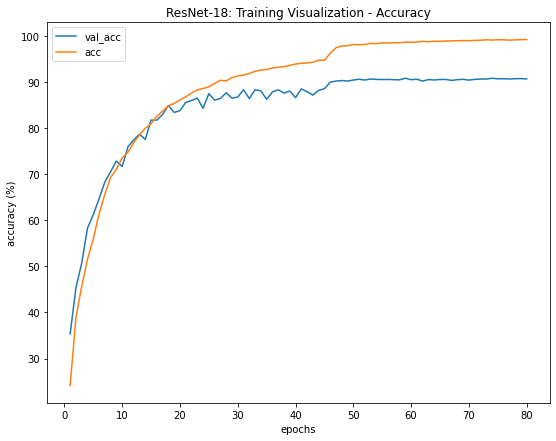

In [49]:
# Visualize accuracies-
plt.figure(figsize = (9, 7))
plt.plot(list(train_hist.keys()), [train_hist[x]['val_acc'] for x in train_hist.keys()], label = 'val_acc')
plt.plot(list(train_hist.keys()), [train_hist[x]['acc'] for x in train_hist.keys()], label = 'acc')
plt.title("ResNet-18: Training Visualization - Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

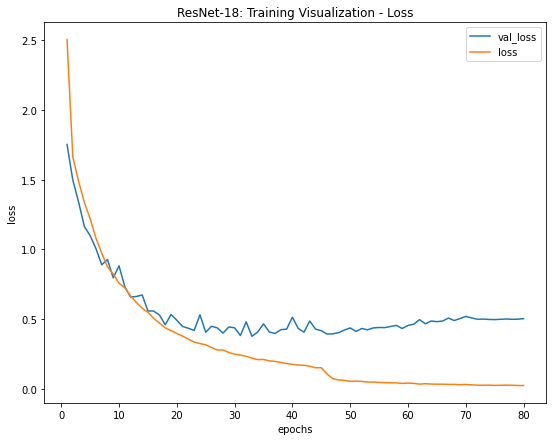

In [50]:
# Visualize losses-
plt.figure(figsize = (9, 7))
plt.plot(list(train_hist.keys()), [train_hist[x]['val_loss'] for x in train_hist.keys()], label = 'val_loss')
plt.plot(list(train_hist.keys()), [train_hist[x]['loss'] for x in train_hist.keys()], label = 'loss')
plt.title("ResNet-18: Training Visualization - Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

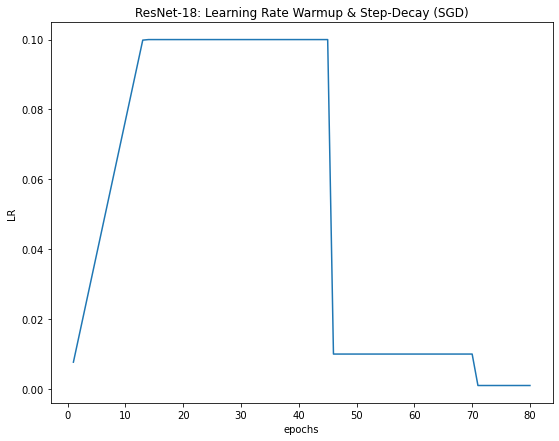

In [51]:
# Visualize learning rate during training-
plt.figure(figsize = (9, 7))
plt.plot(list(train_hist.keys()), [train_hist[x]['lr'] for x in train_hist.keys()])
plt.title("ResNet-18: Learning Rate Warmup & Step-Decay (SGD)")
plt.xlabel("epochs")
plt.ylabel("LR")
plt.show()